<a href="https://colab.research.google.com/github/ddarshana04/Geospatial-Deep-Learning-for-Estimating-Socioeconomic-Well-being-in-Developing-Regions/blob/main/4)Satellite_img_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import os.path
import numpy as np
import time
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

import PIL
import PIL.Image
import tensorflow as tf

In [ ]:
!pip install https://github.com/fastai/fastai1/archive/master.zip

     | 132.1 MB 78.3 MB/s 0:00:09
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastai: filename=fastai-1.0.64.dev0-py3-none-any.whl size=241882 sha256=bef13e7b024ae58b364db0a2651bb973048e79dc77816163bb326f351f308d79
  Stored in directory: /tmp/pip-ephem-wheel-cache-3d00g8mz/wheels/9c/c8/3a/eab2c5dd0c630968f9b114e578eed07b8bde2e38900c376f00
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19171 sha256=c9e1adb3097c498dfe34a108745e0acb72b8dc4c022a3c802d368ec394124a16
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built fastai nvidia-ml-py3
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.13
    Uninstalling fastai-2.7.13:
      Successfully uninstalled fastai-2.7.13


In [ ]:
from fastai.vision import *
from fastai.widgets import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pathlib

In [ ]:
from pathlib import Path
path = Path('/content/drive/MyDrive')

In [ ]:
# add all image filenames into a list
images_name = []
idx_name = []
image_files = []
for i in range(0,63):
  dir_ = str(path)+'/google_images/'+ str(i) + '/'
  try:
    image_files = os.listdir(dir_)
    print(image_files)
    images_name.append(image_files)
    idx_name.append(i)
  except: pass
print(image_files)

['25267_9291.jpg', '25267_9302.jpg', '25267_9369.jpg', '25267_9293.jpg', '25267_9379.jpg', '25267_9375.jpg', '25267_9385.jpg', '25267_9394.jpg', '25267_9307.jpg', '25267_9286.jpg', '25267_9301.jpg', '25267_9373.jpg', '25267_9306.jpg', '25267_9304.jpg', '25267_9387.jpg', '25267_9294.jpg', '25267_9300.jpg', '25267_9408.jpg', '25267_9376.jpg', '25267_9378.jpg', '25267_9288.jpg', '25267_9303.jpg', '25267_9366.jpg', '25267_9296.jpg', '25267_9368.jpg', '25267_9381.jpg', '25267_9392.jpg', '25267_9316.jpg', '25267_9400.jpg', '25267_9430.jpg', '25267_9313.jpg', '25267_9391.jpg', '25267_9382.jpg', '25267_9393.jpg', '25267_9389.jpg', '25267_9401.jpg', '25267_9309.jpg', '25267_9386.jpg', '25267_9384.jpg', '25267_9396.jpg', '25267_9311.jpg', '25267_9390.jpg', '25267_9420.jpg', '25267_9398.jpg', '25267_9412.jpg', '25267_9312.jpg', '25267_9402.jpg', '25267_9315.jpg', '25267_9388.jpg', '25267_9417.jpg', '25267_9403.jpg', '25267_9395.jpg', '25267_9438.jpg', '25267_9407.jpg', '25267_9314.jpg', '25267_94

In [ ]:
all_images_downloaded = []
for i in range(0, len(images_name)):
  list_within = images_name[i]
  for item in list_within:
    all_images_downloaded.append(item)
print('total number of images =',len(all_images_downloaded))

total number of images = 62803


In [ ]:
len_images_name=[]
for i in range(len(images_name)):
  len_images_name.append(len(images_name[i]))
  #print(len(images_name))

In [ ]:
df_test = pd.DataFrame({'idx':idx_name, 'names':len_images_name})
df_test.shape

(63, 2)

In [ ]:
df_test['names'].sum()

62803

# ***Classifying the images into 3 classes***

In [ ]:
### Classify images into three groups
from shutil import copyfile
def move_to_group(lightness_small, lightness_big, class_id):
    path = '/content/drive/MyDrive'
    new_directory = str(path) +'/google_image_cnn/class_' + str(class_id) + '/'
    if not os.path.isdir(new_directory):
        os.makedirs(new_directory)

    for i in range(lightness_small, lightness_big):
        path2 = str(path) + '/google_images/' + str(i) + '/'

        for f in os.listdir(path2):
            copyfile(path2 + f, new_directory + f)



In [ ]:
move_to_group(0, 1, 1)
move_to_group(1, 10, 2)
move_to_group(10, 63, 3)

# ***Extract "basic" features from daytime imagery***

In [ ]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
import io
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib
import pandas as pd
import numpy as np

def read_raster(raster_file):
    """
    Function
    --------
    read_raster

    Given a raster file, get the pixel size, pixel location, and pixel value

    Parameters
    ----------
    raster_file : string
        Path to the raster file

    Returns
    -------
    x_size : float
        Pixel size
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel
    centroid_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the centroid in each pixel
    centroid_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the centroid in each pixel
    bands_data : numpy.ndarray  shape: (number of rows, number of columns, 1)
        Pixel value
    """
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    # get project coordination
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    # Loop through all raster bands
    for b in range(1, raster_dataset.RasterCount + 1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        no_data_value = band.GetNoDataValue()
    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape

    # Get the metadata of the raster
    geo_transform = raster_dataset.GetGeoTransform()
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = geo_transform

    # Get location of each pixel
    x_size = 1.0 / int(round(1 / float(x_size)))
    y_size = - x_size
    y_index = np.arange(bands_data.shape[0])
    x_index = np.arange(bands_data.shape[1])
    top_left_x_coords = upper_left_x + x_index * x_size
    top_left_y_coords = upper_left_y + y_index * y_size
    # Add half of the cell size to get the centroid of the cell
    centroid_x_coords = top_left_x_coords + (x_size / 2)
    centroid_y_coords = top_left_y_coords + (y_size / 2)

    return (x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data)

# Helper function to get the pixel index of the point
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    """
    Function
    --------
    get_cell_idx

    Given a point location and all the pixel locations of the raster file,
    get the column and row index of the point in the raster

    Parameters
    ----------
    lon : float
        Longitude of the point
    lat : float
        Latitude of the point
    top_left_x_coords : numpy.ndarray  shape: (number of columns,)
        Longitude of the top-left point in each pixel
    top_left_y_coords : numpy.ndarray  shape: (number of rows,)
        Latitude of the top-left point in each pixel

    Returns
    -------
    lon_idx : int
        Column index
    lat_idx : int
        Row index
    """
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx


In [ ]:
def get_image_basic_feature(image_file):
    image = plt.imread(image_file)
    features = []
    for i in range(3):
        image_one_band = image[:, :, i].flatten()
        features.append(image_one_band)
    features = np.asarray(features)
    max_ = np.max(features, axis=1)
    min_ = np.min(features, axis=1)
    mean_ = np.mean(features, axis=1)
    median_ = np.median(features, axis=1)
    std_ = np.std(features, axis=1)
    return np.concatenate([max_, min_, mean_, median_, std_]).tolist()

In [ ]:
import numpy as np
import time

feature_all = []
a = 0
t1 = time.time()

for i, images in enumerate(images_name):
    path = '/content/drive/MyDrive/google_images/' + str(i) + '/'
    print(path)
    for image in images:
        try:
            x, y = [int(idx) for idx in image[:-4].split('_')]
            file_ = path + image
            print(file_)
            feature = get_image_basic_feature(file_)
            feature = [x, y] + feature
            feature_all.append(feature)
            if a % 10000 == 0:
                t2 = time.time()
                print(a)
                print(t2 - t1)
                t1 = time.time()
            a += 1
        except Exception as e:
            print(f"Error processing {image}: {str(e)}")

feature_all = np.asarray(feature_all)
print(feature_all)
np.savetxt('intermediate_files/google_image_features_basic.csv', feature_all)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/google_images/0/25097_9514.jpg
/content/drive/MyDrive/google_images/0/25097_9515.jpg
/content/drive/MyDrive/google_images/0/25097_9516.jpg
/content/drive/MyDrive/google_images/0/25097_9517.jpg
/content/drive/MyDrive/google_images/0/25097_9518.jpg
/content/drive/MyDrive/google_images/0/25097_9519.jpg
/content/drive/MyDrive/google_images/0/25097_9520.jpg
/content/drive/MyDrive/google_images/0/25097_9521.jpg
/content/drive/MyDrive/google_images/0/25097_9522.jpg
/content/drive/MyDrive/google_images/0/25097_9523.jpg
/content/drive/MyDrive/google_images/0/25097_9524.jpg
/content/drive/MyDrive/google_images/0/25097_9525.jpg
/content/drive/MyDrive/google_images/0/25097_9526.jpg
/content/drive/MyDrive/google_images/0/25097_9527.jpg
/content/drive/MyDrive/google_images/0/25097_9528.jpg
/content/drive/MyDrive/google_images/0/25097_9529.jpg
/content/drive/MyDrive/google_images/0/25097_9530.jpg
/content/drive/MyDrive/google_i

FileNotFoundError: [Errno 2] No such file or directory: 'intermediate_files/google_image_features_basic.csv'

In [ ]:
import os
import numpy as np
import time

# Specify the directory path
directory_path = 'intermediate_files/'

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

feature_all = []
a = 0
t1 = time.time()

for i, images in enumerate(images_name):
    path = '/content/drive/MyDrive/google_images/' + str(i) + '/'
    print(path)
    for image in images:
        try:
            x, y = [int(idx) for idx in image[:-4].split('_')]
            file_ = path + image
            print(file_)
            feature = get_image_basic_feature(file_)
            feature = [x, y] + feature
            feature_all.append(feature)
            if a % 10000 == 0:
                t2 = time.time()
                print(a)
                print(t2 - t1)
                t1 = time.time()
            a += 1
        except Exception as e:
            print(f"Error processing {image}: {str(e)}")

feature_all = np.asarray(feature_all)

# Save the CSV file to the specified directory
csv_file_path = os.path.join(directory_path, 'google_image_features_basic.csv')
np.savetxt(csv_file_path, feature_all)

print(f"CSV file saved to: {csv_file_path}")

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/google_images/0/25097_9506.jpg
/content/drive/MyDrive/google_images/0/25097_9507.jpg
/content/drive/MyDrive/google_images/0/25097_9508.jpg
/content/drive/MyDrive/google_images/0/25097_9509.jpg
/content/drive/MyDrive/google_images/0/25097_9510.jpg
/content/drive/MyDrive/google_images/0/25097_9511.jpg
/content/drive/MyDrive/google_images/0/25097_9512.jpg
/content/drive/MyDrive/google_images/0/25097_9513.jpg
/content/drive/MyDrive/google_images/0/25097_9514.jpg
/content/drive/MyDrive/google_images/0/25097_9515.jpg
/content/drive/MyDrive/google_images/0/25097_9516.jpg
/content/drive/MyDrive/google_images/0/25097_9517.jpg
/content/drive/MyDrive/google_images/0/25097_9518.jpg
/content/drive/MyDrive/google_images/0/25097_9519.jpg
/content/drive/MyDrive/google_images/0/25097_9520.jpg
/content/drive/MyDrive/google_images/0/25097_9521.jpg
/content/drive/MyDrive/google_images/0/25097_9522.jpg
/content/drive/MyDrive/google_i

In [ ]:
print("Size of feature_all:", feature_all.shape)

Size of feature_all: (59130, 17)


In [ ]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'intermediate_files/google_image_features_basic.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Display the first five rows of the DataFrame
print(df.head())


  2.526700000000000000e+04 9.291000000000000000e+03 1.500000000000000000e+02 1.550000000000000000e+02 1.490000000000000000e+02 0.000000000000000000e+00 5.000000000000000000e+00 2.000000000000000000e+00 5.873567500000000052e+01 7.219060000000000343e+01 6.860067499999999541e+01 5.800000000000000000e+01 7.400000000000000000e+01 7.000000000000000000e+01 1.954023368064913768e+01 1.643381032019050636e+01 1.528088641225943611e+01
0  2.526700000000000000e+04 9.302000000000000000e...                                                                                                                                                                                                                                                                                                                                                                                      
1  2.526700000000000000e+04 9.369000000000000000e...                                                                                              

# ***Merge daytime image data with DHS***

In [ ]:
features_basic = np.loadtxt('intermediate_files/google_image_features_basic.csv')

In [ ]:
# help file
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

def get_daytime_feature(sample):
    idx, wealth, x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    features_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            feature = features_basic[((features_basic[:,0]==i) & (features_basic[:,1]==j)),][:,2:]
            if len(feature) > 0:
                features_100.append(feature)
    if len(features_100) == 0:
        return np.asarray([np.nan] * 15 + [wealth]).tolist()
    else:
        features_all = np.concatenate(features_100, axis=0)
        mean_ = np.mean(features_all, axis=0).tolist()
        mean_.append(wealth)
        return mean_

In [ ]:
clusters = pd.read_csv(str(path)+'/intermediate_files/BU_cluster_avg_asset_2010.csv')
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

np.savetxt(str(path)+'/intermediate_files/DHS_daytime.csv', data_all)

# ***Fit a model of wealth as a function of basic daytime features***

**INPUT:**
data/model/DHS_daytime.csv

**OUTPUT:**
R^2 of model

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import numpy as np


data_all = np.loadtxt(str(path)+'/intermediate_files/DHS_daytime.csv')
alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print('R^2 of the best model: {:.3f}'.format(np.max(final)))

R^2 of the best model: 0.431


# ***IMAGE PREPROCESS***

In [ ]:
image_path = str(path)+'/google_image_cnn/'
def plt_display(image, title):
  fig = plt.figure()
  a = fig.add_subplot(1, 1, 1)
  imgplot = plt.imshow(image)
  a.set_title(title)

In [ ]:

!pip install fastai
!pip install torch torchvision --upgrade
!pip install fastai --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 742.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 11.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existing installation: torch 2.2.0
    Uninstalling torch-2

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


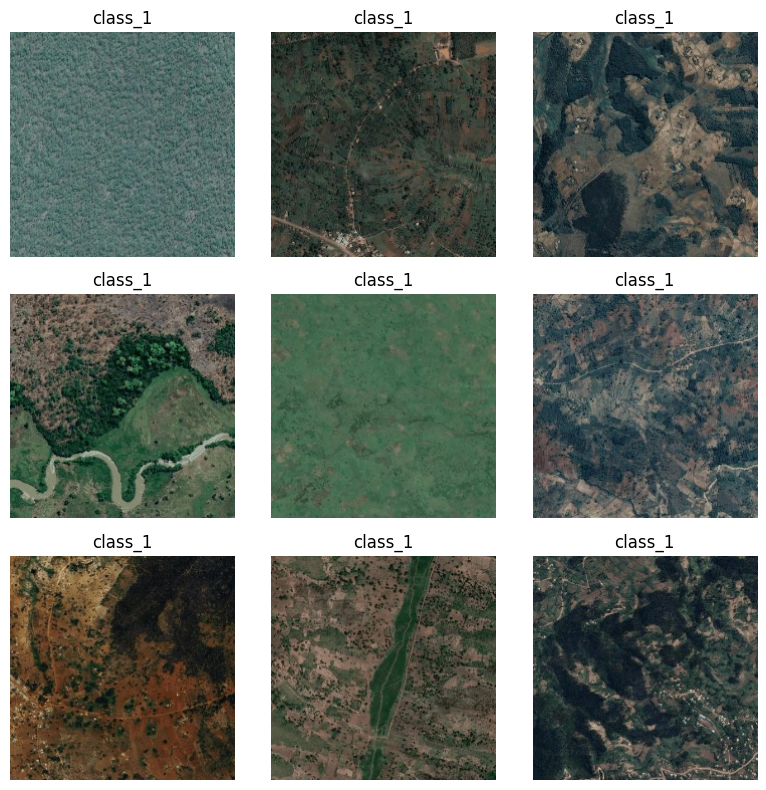

In [ ]:
from fastai.vision import *
import numpy as np
import torch
path_1 = Path('/content/drive/My Drive/google_image_cnn/class_1')
np.random.seed(42)
data_1 = ImageDataBunch.from_folder(path_1, train=".", valid_pct=0.2,ds_tfms=None,
                                     size=224, num_workers=4).normalize(imagenet_stats)

data_1.show_batch(rows=3, figsize=(8, 8))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


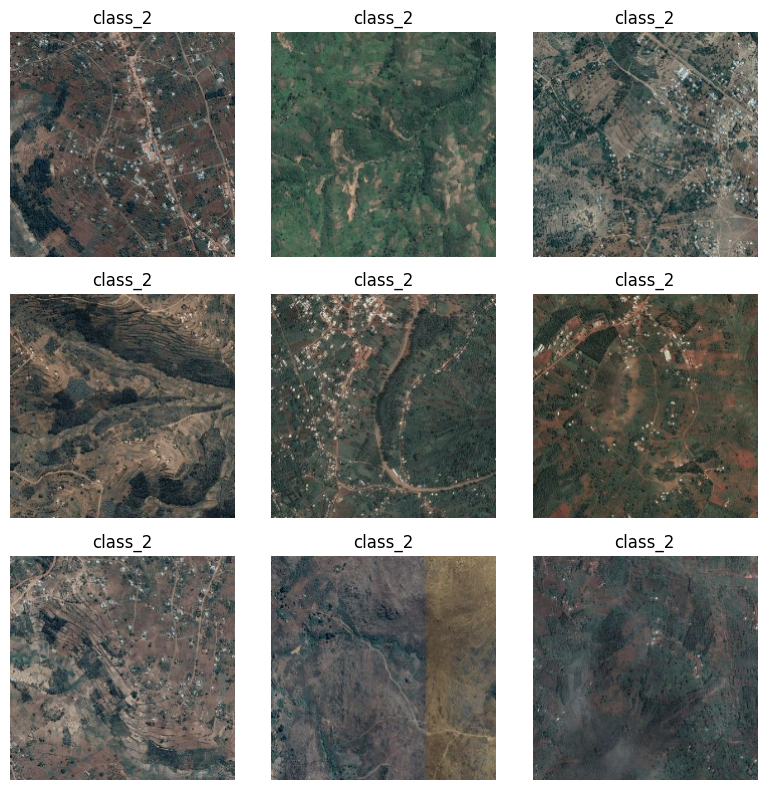

In [ ]:
from fastai.vision import *
import numpy as np
import torch
path_2 = Path('/content/drive/My Drive/google_image_cnn/class_2')
np.random.seed(42)
data_2 = ImageDataBunch.from_folder(path_2, train=".", valid_pct=0.2,ds_tfms=None,
                                     size=224, num_workers=4).normalize(imagenet_stats)

data_2.show_batch(rows=3, figsize=(8, 8))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


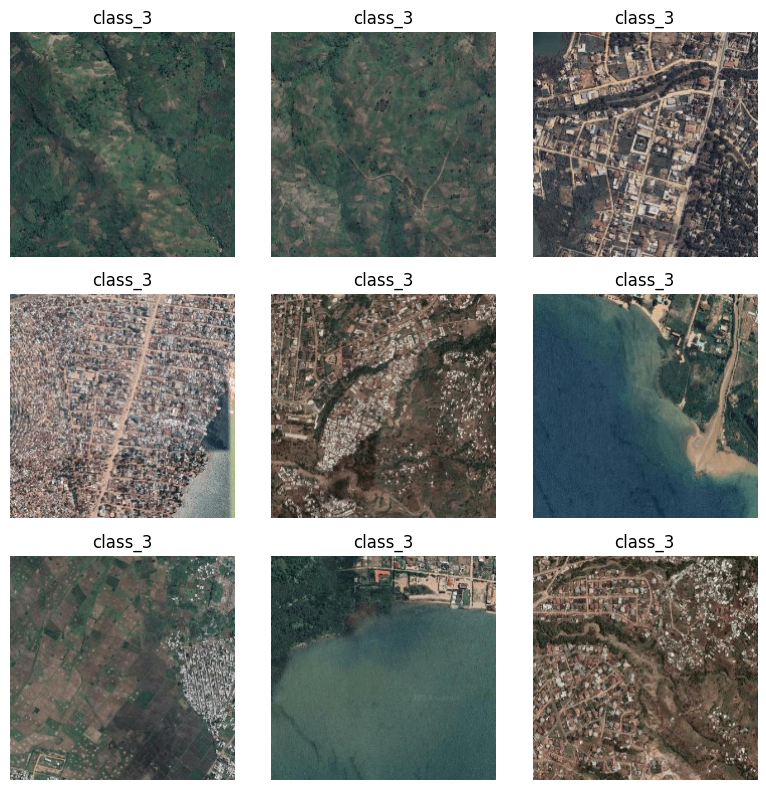

In [ ]:
from fastai.vision import *
import numpy as np
import torch
path_3 = Path('/content/drive/My Drive/google_image_cnn/class_3')
np.random.seed(42)
data_3 = ImageDataBunch.from_folder(path_3, train=".", valid_pct=0.2,ds_tfms=None,
                                     size=224, num_workers=4).normalize(imagenet_stats)

data_3.show_batch(rows=3, figsize=(8, 8))


# ***BALANCE DATASET***

In [ ]:
# # Creating Train / Test folders
root_dir = '/content/drive/My Drive/google_image_cnn/'
classes_dir = ['class_1', 'class_2', 'class_3']

for cls in classes_dir:
    os.makedirs(root_dir +cls+'_bal')
    src = root_dir + cls # Folder to copy images from
    allFileNames = os.listdir(src)
    np.random.choice(allFileNames, 238, replace=False) # balance the images

# ***CREATE TRAIN TEST SETS***

In [ ]:
import os
import numpy as np
import shutil
import random

root_dir = '/content/drive/My Drive/google_image_cnn/'
classes_dir = ['class_1', 'class_2', 'class_3']

test_ratio = 0.2

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'test/' + cls)

    # Creating partitions of the data after shuffling
    src = root_dir + cls # Folder to copy images from

    allFileNames1 = os.listdir(src)
    allFileNames=np.random.choice(allFileNames1, 238, replace=False)
    #np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - test_ratio))])

    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))

     # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'train/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'test/' + cls)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.layers import Convolution2D, AveragePooling2D, Activation, Flatten, Dense, Dropout
from multiprocessing import Pool
import os
import time


In [ ]:
# load pre-trained model
from tensorflow.keras.applications.vgg16 import VGG16
model_vgg16 = VGG16(weights='imagenet', include_top=False)


In [ ]:

from tensorflow.keras.applications.resnet50 import ResNet50
model_ResNet50 = ResNet50(weights='imagenet')

In [ ]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
model_inceptionV3 = InceptionV3(weights='imagenet', include_top=False)

In [ ]:
def get_input_feature(img_path):
    # img = image.load_img(img_path, target_size=(400, 400))
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_inceptionV3.predict(x)
    return features[0]

In [ ]:
# train
all_figures = []
trainLabels = []

path_1 = '/content/drive/My Drive/google_image_cnn/train/class_1/'
class_1_files = os.listdir(path_1)
trainLabels += [[1, 0, 0]] * len(class_1_files)
all_figures += [path_1 + i for i in class_1_files]

path_2 = '/content/drive/My Drive/google_image_cnn/train/class_2/'
class_2_files = os.listdir(path_2)
trainLabels += [[0, 1, 0]] * len(class_2_files)
all_figures += [path_2 + i for i in class_2_files]

path_3 = '/content/drive/My Drive/google_image_cnn/train/class_3/'
class_3_files = os.listdir(path_3)
trainLabels += [[0, 0, 1]] * len(class_3_files)
all_figures += [path_3 + i for i in class_3_files]

In [ ]:
trainData = []
t1 = time.time()
for idx, i in enumerate(all_figures):
    a = get_input_feature(i)
    trainData.append(a)
    if idx % 100 == 0:
        t2 = time.time()
        print(idx)
        print((t2 - t1), 'sec')
        t1 = time.time()

1/1 [==============================] - 6s 6s/step
0
6.276624441146851 sec
1/1 [==============================] - 0s 148ms/step
100
29.86407470703125 sec
1/1 [==============================] - 0s 144ms/step
200
25.278141498565674 sec
1/1 [==============================] - 0s 148ms/step
300
25.949989795684814 sec
1/1 [==============================] - 0s 147ms/step
400
29.542229413986206 sec
1/1 [==============================] - 0s 150ms/step
500
25.575523614883423 sec
1/1 [==============================] - 0s 155ms/step


In [ ]:
x_all = np.asarray(trainData)
y_all = np.asarray(trainLabels)

# test
all_figures = []
testLabels = []

path_1 = '/content/drive/My Drive/google_image_cnn/test/class_1/'
# path_1 = 'google_image_cnn/class_1/'
class_1_files = os.listdir(path_1)
testLabels += [[1, 0, 0]] * len(class_1_files)
all_figures += [path_1 + i for i in class_1_files]

path_2 = '/content/drive/My Drive/google_image_cnn/test/class_2/'
# path_2 = 'google_image_cnn/class_2/'
class_2_files = os.listdir(path_2)
testLabels += [[0, 1, 0]] * len(class_2_files)
all_figures += [path_2 + i for i in class_2_files]

path_3 = '/content/drive/My Drive/google_image_cnn/test/class_3/'
# path_3 = 'google_image_cnn/class_3/'
class_3_files = os.listdir(path_3)
testLabels += [[0, 0, 1]] * len(class_3_files)
all_figures += [path_3 + i for i in class_3_files]



In [ ]:
testData = []
t1 = time.time()
for idx, i in enumerate(all_figures):
    a = get_input_feature(i)
    testData.append(a)
    if idx % 1000 == 0:
        t2 = time.time()
        print(idx)
        print(t2 - t1, 'sec')
        t1 = time.time()

x_all_test = np.asarray(testData)
y_all_test = np.asarray(testLabels)

1/1 [==============================] - 0s 143ms/step
0
0.2259373664855957 sec
1/1 [==============================] - 0s 150ms/step


In [ ]:
np.savez('/content/drive/My Drive/google_image_feature_InceptionV3.npz', x_all=x_all, y_all=y_all, x_all_test=x_all_test, y_all_test=y_all_test)

In [ ]:
x_train = x_all
x_test = x_all_test
y_train = y_all
y_test = y_all_test

In [ ]:
from skimage.transform import resize

# Assuming x_train has shape (batch_size, 5, 5, 2048)
x_train_resized = resize(x_train, (x_train.shape[0], 12, 12, 512))

model = Sequential()
model.add(Convolution2D(4096, (6, 6), activation='relu', input_shape=(12, 12, 512), strides=(6, 6), name='input'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu', strides=(1, 1), name='conv_7'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), strides=(1, 1), name='conv_8'))
model.add(AveragePooling2D((2, 2), strides=(1, 1), name='add_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(3))
model.add(Activation("softmax"))


In [ ]:
from tensorflow.keras.optimizers import SGD

opt = SGD(lr=1e-3)  # Adjust the learning rate
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
#Data Augmentation (optional):
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train_resized)

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:2092: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (565, 12, 12, 512) (512 channels).
  warnings.warn(


In [ ]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive

# Define a checkpoint callback to save the model every 10 epochs
checkpoint_path = '/content/drive/MyDrive/your_folder/weights.{epoch:02d}.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_freq=10)

start_time = time.time()

# Train the model with the checkpoint callback
model.fit(x_train_resized, y_train, batch_size=100, epochs=200, verbose=1, callbacks=[checkpoint_callback])

end_time = time.time()
elapsed_time_seconds = end_time - start_time

# Convert seconds to hours
elapsed_time_hours = elapsed_time_seconds / 3600

print(f"Training time: {elapsed_time_hours:.2f} hours")

Epoch 1/200
6/6 [==============================] - 539s 85s/step - loss: 1.1444 - accuracy: 0.3789
Epoch 2/200
6/6 [==============================] - 556s 93s/step - loss: 1.0863 - accuracy: 0.4158
Epoch 3/200
6/6 [==============================] - 538s 89s/step - loss: 1.0706 - accuracy: 0.4140
Epoch 4/200
6/6 [==============================] - 513s 84s/step - loss: 1.0393 - accuracy: 0.4912
Epoch 5/200
6/6 [==============================] - 524s 86s/step - loss: 1.0734 - accuracy: 0.4561
Epoch 6/200
6/6 [==============================] - 508s 83s/step - loss: 1.0325 - accuracy: 0.4754
Epoch 7/200
6/6 [==============================] - 524s 85s/step - loss: 1.0571 - accuracy: 0.4526
Epoch 8/200
6/6 [==============================] - 520s 86s/step - loss: 1.0544 - accuracy: 0.4737
Epoch 9/200
6/6 [==============================] - 522s 87s/step - loss: 1.0327 - accuracy: 0.4614
Epoch 10/200
6/6 [==============================] - 517s 86s/step - loss: 1.0262 - accuracy: 0.4614
Epoch 11/

In [ ]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive

# Define a checkpoint callback to save the model every 10 epochs
checkpoint_path = '/content/drive/MyDrive/your_folder/weights.{epoch:02d}.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_freq=10)

start_time = time.time()

# Train the model with the checkpoint callback
model.fit(x_train_resized, y_train, batch_size=100, epochs=200, verbose=1, callbacks=[checkpoint_callback])

end_time = time.time()
elapsed_time_seconds = end_time - start_time

# Convert seconds to hours
elapsed_time_hours = elapsed_time_seconds / 3600

print(f"Training time: {elapsed_time_hours:.2f} hours")

Epoch 1/200
6/6 [==============================] - 539s 85s/step - loss: 1.1444 - accuracy: 0.3789
Epoch 2/200
6/6 [==============================] - 556s 93s/step - loss: 1.0863 - accuracy: 0.4158
Epoch 3/200
6/6 [==============================] - 538s 89s/step - loss: 1.0706 - accuracy: 0.4140
Epoch 4/200
6/6 [==============================] - 513s 84s/step - loss: 1.0393 - accuracy: 0.4912
Epoch 5/200
6/6 [==============================] - 524s 86s/step - loss: 1.0734 - accuracy: 0.4561
Epoch 6/200
6/6 [==============================] - 508s 83s/step - loss: 1.0325 - accuracy: 0.4754
Epoch 7/200
6/6 [==============================] - 524s 85s/step - loss: 1.0571 - accuracy: 0.4526
Epoch 8/200
6/6 [==============================] - 520s 86s/step - loss: 1.0544 - accuracy: 0.4737
Epoch 9/200
6/6 [==============================] - 522s 87s/step - loss: 1.0327 - accuracy: 0.4614
Epoch 10/200
6/6 [==============================] - 517s 86s/step - loss: 1.0262 - accuracy: 0.4614
Epoch 11/

Example

In [ ]:
import tensorflow as tf

# Attempt to load the model using load_model
try:
    model = tf.keras.models.load_model('/content/drive/MyDrive/your_folder/weights.77.h5')

    # If successful, it contains both architecture and weights
    print("The .h5 file contains both model architecture and weights.")

    # Print model summary to verify architecture
    model.summary()

except:
    # If loading fails, it likely only contains weights
    print("The .h5 file likely only contains model weights.")


The .h5 file likely only contains model weights.


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/your_folder/weights.77.h5')
history = model.history.history  # Access the saved history
print(history['accuracy'], history['loss'])


ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x79e97f354100>.

In [ ]:
import h5py

# Open the .h5 file in read-only mode
with h5py.File('/content/drive/MyDrive/your_folder/weights.77.h5', 'r') as f:

    # Keys to inspect
    keys_to_view = ['activation_94', 'add_pool', 'conv_7', 'conv_8', 'dense', 'dropout', 'dropout_1', 'flatten', 'input', 'top_level_model_weights']

    # Iterate through the keys and print their values
    for key in keys_to_view:
        try:
            print(f"\nKey: {key}")
            print(f.get(key))  # Print attributes and data for datasets
        except KeyError:
            print(f"Key '{key}' not found in the file.")



Key: activation_94
<HDF5 group "/activation_94" (0 members)>

Key: add_pool
<HDF5 group "/add_pool" (0 members)>

Key: conv_7
<HDF5 group "/conv_7" (1 members)>

Key: conv_8
<HDF5 group "/conv_8" (1 members)>

Key: dense
<HDF5 group "/dense" (1 members)>

Key: dropout
<HDF5 group "/dropout" (0 members)>

Key: dropout_1
<HDF5 group "/dropout_1" (0 members)>

Key: flatten
<HDF5 group "/flatten" (0 members)>

Key: input
<HDF5 group "/input" (1 members)>

Key: top_level_model_weights
<HDF5 group "/top_level_model_weights" (0 members)>


In [ ]:
from tensorflow.keras.models import load_model

# Load the model architecture
#model = load_model('/content/drive/MyDrive/your_folder/complete_model.h5')

# Load the model and weights:
model.load_weights('/content/drive/MyDrive/your_folder/weights.77.h5')


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define a checkpoint to save weights during training
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/your_folder/weights.{epoch:02d}.h5',
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch',  # Save weights after each epoch
    verbose=1
)

# Add early stopping to prevent training if the model is not improving
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Monitor training loss
    patience=10,       # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    verbose=1
)

# Reduce the learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model before training
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Resume training with updated callbacks
model.fit(
    x_train_resized, y_train,
    batch_size=100,
    epochs=200,
    initial_epoch=77,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 78/200
6/6 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3274  
Epoch 78: saving model to /content/drive/MyDrive/your_folder/weights.78.h5
6/6 [==============================] - 493s 81s/step - loss: nan - accuracy: 0.3274
Epoch 79/200
6/6 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3274  
Epoch 79: saving model to /content/drive/MyDrive/your_folder/weights.79.h5
6/6 [==============================] - 515s 87s/step - loss: nan - accuracy: 0.3274
Epoch 80/200
6/6 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3274  
Epoch 80: saving model to /content/drive/MyDrive/your_folder/weights.80.h5
6/6 [==============================] - 566s 91s/step - loss: nan - accuracy: 0.3274
Epoch 81/200
6/6 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3274  
Epoch 81: saving model to /content/drive/MyDrive/your_folder/weights.81.h5
6/6 [==============================] - 547s 90s/step - loss: nan - accuracy:

In [ ]:
from tensorflow.keras.optimizers import Adam

# Recompile the model with the optimizer and learning rate
optimizer = Adam(learning_rate=0.0001)  # Adjust the learning rate if needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 2, 2, 4096)        75501568  
                                                                 
 dropout (Dropout)           (None, 2, 2, 4096)        0         
                                                                 
 conv_7 (Conv2D)             (None, 2, 2, 4096)        16781312  
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 4096)        0         
                                                                 
 conv_8 (Conv2D)             (None, 2, 2, 4096)        16781312  
                                                                 
 add_pool (AveragePooling2D)  (None, 1, 1, 4096)       0         
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [ ]:
# Example: Resize test data (if needed)
x_test_resized = resize(x_test, (x_test.shape[0], 12, 12, 512))

# Evaluate the model
score = model.evaluate(x_test_resized, y_test, verbose=0)
print(f"Test Loss: {score[0]}, Test Accuracy: {score[1]}")


In [ ]:
from skimage.transform import resize

# Assuming x_test has shape (batch_size, 5, 5, 2048)
x_test_resized = resize(x_test, (x_test.shape[0], 12, 12, 512))

# Evaluate the model using the resized test data
score = model.evaluate(x_test_resized, y_test, verbose=0)
print(score)


[nan, 0.3333333432674408]
